In [71]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from decifer  import Tokenizer
import matplotlib.pyplot as plt

class HDF5Dataset(Dataset):
    def __init__(self, h5_file_path, data_to_load, block_size, numeric_padding_value=0):
        self.h5_file = h5py.File(h5_file_path, 'r')
        self.data_to_load = data_to_load
        self.block_size = block_size
        self.data = {key: self.h5_file[key] for key in self.data_to_load}
        
        self.token_padding_value = Tokenizer().padding_id
        self.numeric_padding_value = numeric_padding_value

    def __len__(self):
        total_chunks = 0
        for key in self.data_to_load:
            for sequence in self.data[key]:
                total_chunks += (len(sequence) + self.block_size - 1) // self.block_size
        return total_chunks

    def __getitem__(self, idx):
        sequence_chunks = self.find_sequence_and_chunk(idx)
        data = []
        block_size = self.block_size  # Cache the block size for faster access

        for key in self.data_to_load:
            sequence = self.data[key][sequence_chunks['sequence_idx']]
            chunk = None

            # Handle tokenized data
            if 'tokenized' in key:
                start = sequence_chunks['chunk_idx'] * block_size
                end = min(start + block_size, len(sequence))
                chunk = sequence[start:end]
            else:
                chunk = sequence

            # Handle numeric data (np.ndarray)
            if isinstance(chunk, np.ndarray):
                dtype = torch.float32 if 'float' in str(chunk.dtype) else torch.long
                chunk = torch.tensor(chunk, dtype=dtype)

            # Handle tokenized data (strings)
            elif isinstance(chunk, (bytes, str)):
                chunk = chunk.decode('utf-8') if isinstance(chunk, bytes) else chunk

            # Pad if necessary
            if isinstance(chunk, torch.Tensor) and len(chunk) < block_size:
                pad_value = self.token_padding_value if chunk.dtype == torch.long else self.numeric_padding_value
                chunk = torch.cat([chunk, torch.full((block_size - len(chunk),), pad_value, dtype=chunk.dtype)], dim=0)

            data.append(chunk)

        return tuple(data)

    def find_sequence_and_chunk(self, idx):
        total_chunks = 0
        for key in self.data_to_load:
            for i, sequence in enumerate(self.data[key]):
                num_chunks = (len(sequence) + self.block_size - 1) // self.block_size
                if idx < total_chunks + num_chunks:
                    chunk_idx = idx - total_chunks
                    return {'sequence_idx': i, 'chunk_idx': chunk_idx}
                total_chunks += num_chunks
        raise IndexError("Index out of bounds")

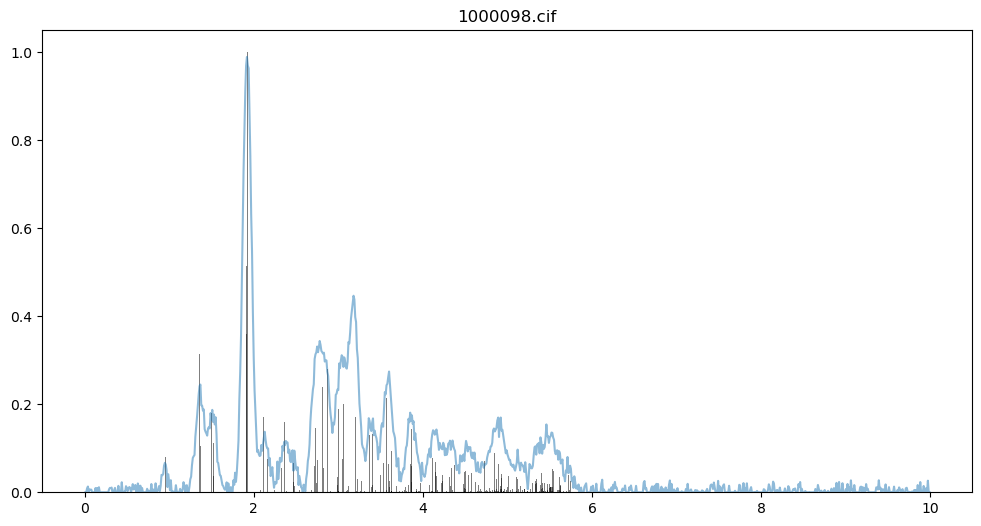

0.9572, 0.0796
1.2316, 0.0008
1.3340, 0.0008
1.3579, 0.3144
1.3676, 0.0000
1.3731, 0.1045
1.4006, 0.0001
1.5003, 0.1810
1.5216, 0.1123
1.5266, 0.0376
1.5683, 0.0002
1.7043, 0.0001
1.8123, 0.0005
1.8156, 0.0014
1.9105, 0.5139
1.9145, 0.3589
1.9312, 1.0000
2.0589, 0.0003
2.0597, 0.0000
2.0845, 0.0045
2.1155, 0.1716
2.1650, 0.0753
2.1886, 0.0008
2.2504, 0.0041
2.3244, 0.0550
2.3497, 0.0003
2.3656, 0.1594
2.3903, 0.0030
2.4237, 0.0000
2.4268, 0.0001
2.4540, 0.0001
2.4670, 0.0669
2.4748, 0.0227
2.4817, 0.0146
2.5424, 0.0059
2.5519, 0.0003
2.5800, 0.0011
2.6648, 0.0030
2.6680, 0.0007
2.6783, 0.0057
2.6997, 0.0003
2.7158, 0.0590
2.7242, 0.1841
2.7352, 0.1462
2.7374, 0.0200
2.7463, 0.0013
2.7549, 0.0732
2.7601, 0.0267
2.8012, 0.0004
2.8154, 0.2389
2.8261, 0.0543
2.8717, 0.2799
2.8895, 0.0177
2.9045, 0.0026
2.9386, 0.0002
2.9902, 0.0339
2.9922, 0.0162
2.9978, 0.0025
2.9981, 0.1884
3.0006, 0.0030
3.0432, 0.1199
3.0532, 0.0745
3.0637, 0.2017
3.0948, 0.0036
3.1057, 0.0041
3.1173, 0.0146
3.1366, 0.

In [74]:
tok = Tokenizer()

# Example usage:
block_size = 2048  # Transformer context length
dataset = HDF5Dataset('../data/chili100k/hdf5_data/train_dataset.h5', 
                      ['name', 'xrd_cont_x', 'xrd_cont_y', 'xrd_discrete_x', 
                       'xrd_discrete_y', 'xrd_tokenized', 'cif_tokenized', 'cif_content']
                      , block_size)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


for batch in dataloader:
    for ni, x, y, xd, yd, xrd_tokens, cif_tokens, cif_content in zip(*batch):
        plt.figure(figsize=(12,6))
        plt.title(ni)
        plt.bar(xd,yd, width=0.01, color='k', alpha=0.5)
        plt.plot(x[x!=0],y[x != 0], alpha=0.5)
        plt.show()
        xrd_tokens = xrd_tokens[xrd_tokens != tok.padding_id]
        print(tok.decode(list(xrd_tokens.numpy())))
        cif_tokens = cif_tokens[cif_tokens != tok.padding_id]
        print(tok.decode(list(cif_tokens.numpy())))
        break
    break

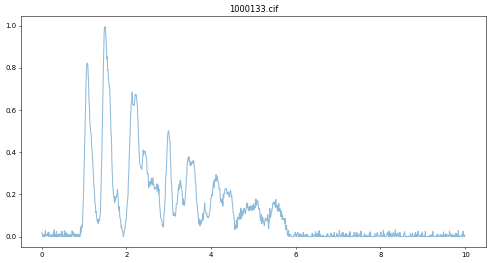

data_Pd(NO4)2
_symmetry_space_group_name_H-M   Pbca
_cell_length_a   5.00360000
_cell_length_b   10.60730000
_cell_length_c   11.72230000
_cell_angle_alpha   90.00000000
_cell_angle_beta   90.00000000
_cell_angle_gamma   90.00000000
_symmetry_Int_Tables_number   61
_chemical_formula_structural   Pd(NO4)2
_chemical_formula_sum   'Pd4 N8 O32'
_cell_volume   622.15739498
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_type_symbol
_atom_type_oxidation_number
Pd2+  2.0
N5+  5.0
O2-  -2.0
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Pd2+  Pd0  4  0.00000000  0.00000000  0.00000000  1.0
N5+  N1  8  0.15000000  0.16570000  0.38100000  1.0
O2-  O2  8  0.05300000  0.69900000  0.17280000  1.0
O2-  O3  8  0.17700000  0.04440000  0.41380000  1.0
O2-  O4  8  0.18900000  0.74440000  0.41580000  1.0
O2-  O5  8  0.19300000  0.556

In [78]:
tok = Tokenizer()

# Example usage:
block_size = 128  # Transformer context length
dataset = HDF5Dataset('../data/chili100k/hdf5_data/train_dataset.h5', 
                      ['name', 'xrd_cont_x', 'xrd_cont_y', 'xrd_tokenized', 'cif_tokenized', 'cif_content']
                      , block_size)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


for batch in dataloader:
    for ni, x, y, xrd_tokens, cif_tokens, cif_content in zip(*batch):
        plt.figure(figsize=(12,6), dpi=50)
        plt.title(ni)
        plt.plot(x[x!=0],y[x != 0], alpha=0.5)
        plt.show()
        print(cif_content)
        break
    break